In [68]:
import pandas as pd
import numpy as np
from scipy import io
import plotly.express as px
import math
import re
import random as rnd
import json
import warnings
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from IPython.display import Image

pd.set_option('display.max_columns', 100)

# Direct BEA to OECD Matrix

## VL's Production Assumptions

These assumptions follow VomLehn-Winberry, however, some subcategories were chosen by me as VW were always aggregating into their sector groups rather than at the BEA sector level.

### Equipment

VL Maps Commodity Codes from the PEQ bridge and Asset Codes from the Investment tables into 25 NIPA categories (ignoring residential equipment). The split production is weighted by the PEQ bridge.

### Structures

1. Mining structures (SM02) are produced by mining support activities (2130)
2. All other structures are produced by construction (2300)

### Intellectual Property

1. Prepackaged software (ENS1) is produced by publishing industries (5110)
2. Custom software (ENS2) is produced by computer systems design (5415)
3. Own-account software (ENS3) is produced by computer systems design (5415)
4. Scientific research and development services (RD11-92) is produced by misc. professional, scientific, and technical services (5412)
5. Theatrical movies (AE10) are produced by motion picutre and sound recording industries (5120)
6. Long-lived television programs (AE20) are produced by radio and television broadcasting (5150) (not included)
7. Books (AE30) are produced by publishing industries (5110)
8. Music (AE40) are produced by motion picture and sound recording industries (5120)
9. Other entertainment originals (AE50) are categorized under Art, entertainment, and recreation (7100) but for now placed in subcategory Performing Arts, spectator sports, and related activities (711A)

## Expenditure Data

In [69]:
expend_df = pd.read_csv("raw_data/BEA_Expenditures.csv", index_col=0)
expend_df = expend_df.apply(lambda x: [i.replace(",","") if type(i) is str else i for i in x])
expend_df = expend_df.astype(float)
expend_df["industry"] = expend_df.index.map(lambda x: x[3:7])
expend_df["asset"] = expend_df.index.map(lambda x: x[8:-2])
expend_df = expend_df[expend_df["asset"].map(lambda x: x not in ["EQ00", "ST00"])]

## Non-Residential Equipment Investment Network

In [70]:
# map assets in expenditure data to NIPA categories in the bridge file
asset_nipa = {
    "EP1A": 4,
    "EP1B": 4,
    "EP1C": 4,
    "EP1D": 4,
    "EP1E": 4,
    "EP1F": 4,
    "EP1G": 4,
    "EP1H": 4,
    "EP20": 5,
    "EP34": 6,
    "EP35": 6,
    "EP36": 7,
    "EP31": 8,
    "EP12": 9,
    "EI11": 11,
    "EI12": 11,
    "EI21": 12,
    "EI22": 12,
    "EI30": 13,
    "EI40": 14,
    "EI50": 15,
    "EI60": 16,
    "ET11": 19,
    "ET12": 20,
    "ET20": 21,
    "ET30": 22,
    "ET40": 23,
    "ET50": 24,
    "EO11": 26,
    "EO12": 26,
    "EO30": 27,
    "EO21": 27,
    "EO40": 28,
    "EO22": 28,
    "EO50": 29,
    "EO60": 30,
    "EO71": 34,
    "EO72": 32,
    "EO80": 32
}

In [71]:
# the bridge file contains the 
def read_bridge(year):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        equip_df = pd.read_excel("PEQBridge_1997-2021_SUM.xlsx", sheet_name=year, header=4)
        equip_df.columns = ["nipa", "peq_name", "code", "description","prod_val","trans_costs", "wholesale", "retail", "buy_val", "year"]
        equip_df = equip_df[~(equip_df["code"] == "Used")]
        equip_df["code"] = equip_df["code"].map(lambda x: re.sub(r"[a-zA-Z]", "", str(x)))
        equip_df["code"] = equip_df["code"].map(lambda x: x + "0" if len(x) == 3 else x)

        equip_df["code"] = equip_df["code"].map(lambda x: x.replace("1","M") if x == "3361" else x)
        equip_df["code"] = equip_df["code"].map(lambda x: x.replace("4","O") if x == "3364" else x)
        equip_df["code"] = equip_df["code"].map(lambda x: x.replace("0","T") if x == "3130" else x)

        equip_df = equip_df[~(equip_df["code"] == "Used")]
        equip_df = equip_df[["nipa", "code", "prod_val", "trans_costs","wholesale","retail"]]
        
    return equip_df

years = [str(y) for y in range(2000, 2021)]

# create map for getting asset production weights
nipa_split = {}
for y in years:

    equip_df = read_bridge(y)

    yearly = {}
    for n in equip_df["nipa"].unique():
        # default split includes marginal costs
        temp = {
            "4810": 0,
            "4820": 0,
            "4830": 0,
            "4840": 0,
            "4850": 0,
            "487S": 0,
            "4930": 0,
            "4200": 0,
            "44RT": 0
        }
        for i, row in equip_df[equip_df["nipa"] == n].iterrows():

            # marginal values
            tot_transport = equip_df[equip_df["nipa"] == n]["trans_costs"].sum()
            tot_wholesale = equip_df[equip_df["nipa"] == n]["wholesale"].sum()
            tot_retail = equip_df[equip_df["nipa"] == n]["retail"].sum()

            # produced value
            tot_prod = equip_df[equip_df["nipa"] == n]["prod_val"].sum()

            # weighted production
            total = tot_transport + tot_wholesale + tot_retail + tot_prod
            temp[row["code"]] = row["prod_val"] / total

            # add transportation margins
            for t in ["4810", "4820", "4830", "4840", "4850", "487S", "4930"]:
                temp[t] = temp[t] + row["trans_costs"] / total / 8
            
            # add wholesale margins
            temp["4200"] = temp["4200"] + row["wholesale"] / total

            # add retail margins
            temp["44RT"] = temp["44RT"] + row["retail"] / total

        yearly[n] = temp
    nipa_split[y] = yearly
    

In [72]:
# get just equipment expenditures
equip_expend_df = expend_df[expend_df["asset"].map(lambda x: x[0] == "E")].copy()
# remove software products
equip_expend_df = equip_expend_df[equip_expend_df["asset"].map(lambda x: not x in ["ENS1","ENS2","ENS3"])]
equip_expend_df["nipa"] = equip_expend_df["asset"].map(lambda x: asset_nipa[x])

# industry by nipa asset category
equip_expend_df2 = equip_expend_df[years + ["industry", "nipa"]]
equip_expend_df2 = equip_expend_df2.groupby(["industry", "nipa"]).agg("sum")

VL's investment matrix calculation

$$I_{ijt}=\sum_{a=1}^{A}\omega_{iat}I_{ajt}^{exp}$$

In [73]:
industries = expend_df["industry"].unique()
n_industries = len(expend_df["industry"].unique())
equip_matrix = np.zeros((len(years), n_industries, n_industries))

for i in range(n_industries):
    for j in range(n_industries):
        for t in range(len(years)):
            temp = 0
            for a in nipa_split[years[t]].keys():
                try:
                    temp = temp + nipa_split[years[t]][a][industries[i]] * equip_expend_df2.loc[(industries[j],a), years[t]]
                except:
                    continue
                
            equip_matrix[t,i,j] = temp

final_equip_matrix = pd.DataFrame(equip_matrix.mean(axis = 0))
final_equip_matrix.columns = industries
final_equip_matrix.index = industries

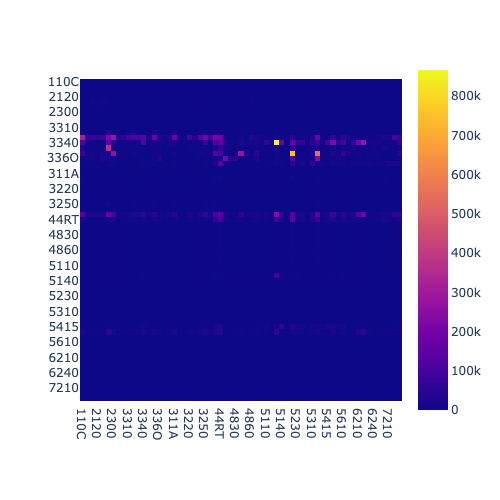

In [74]:
#px.imshow(final_equip_matrix, width=500, height=500)
Image("equipmat.png")

## Non Residential Structures Investment Network

In [75]:
structure_df = expend_df[expend_df["asset"].map(lambda x: x[0] == "S")].copy()
structure_df["asset"] = structure_df["asset"].map(lambda x: "Mining" if x in ["SM02", "SM01"] else "Other")
structure_df = structure_df.groupby(["industry", "asset"]).agg("sum")
structure_matrix = np.zeros((len(years), n_industries, n_industries))

for i in range(n_industries):
    for j in range(n_industries):
        for t in range(len(years)):

            if industries[i] == "2130":
                structure_matrix[t,i,j] = structure_df.loc[(industries[j],"Mining"), years[t]]
            elif industries[i] == "2300":
                structure_matrix[t,i,j] = structure_df.loc[(industries[j],"Other"), years[t]]

final_structure_matrix = pd.DataFrame(structure_matrix.mean(axis = 0))
final_structure_matrix.columns = industries
final_structure_matrix.index = industries

In [76]:
structure_df[structure_df.columns[99:]].head(20)

2000     2001     2002     2003     2004     2005  \
industry asset                                                          
110C     Mining      0.0      0.0      0.0      0.0      0.0      0.0   
         Other    4026.0   4491.0   4699.0   4551.0   4760.0   5251.0   
113F     Mining      0.0      0.0      0.0      0.0      0.0      0.0   
         Other     681.0    494.0    133.0    231.0    315.0    321.0   
2110     Mining  21725.0  32397.0  27560.0  36228.0  43003.0  63506.0   
         Other    1964.0   1654.0   2238.0   3279.0   2601.0   2578.0   
2120     Mining   1110.0    978.0   1902.0   1630.0   3073.0   4263.0   
         Other     702.0    315.0    254.0    358.0    617.0    981.0   
2130     Mining    670.0    987.0    424.0    197.0    674.0    846.0   
         Other     223.0    237.0    339.0    167.0    350.0    337.0   
2200     Mining     14.0     18.0     23.0     21.0     35.0     59.0   
         Other   32447.0  37851.0  24365.0  25526.0  20878.0  21816.0   
2300     Mining     13.0     16.0     20.0     25.0     80.0     45.0   
         Other    2160.0   2421.0   1103.0   1346.0   3383.0   1922.0   
311A     Mining      0.0      0.0      0.0      0.0      0.0      0.0   
         Other    2146.0   2244.0   2456.0   2328.0   2532.0   3161.0   
313T     Mining      0.0      0.0      0.0      0.0      0.0      0.0   
         Other     258.0    245.0    214.0    102.0    151.0    113.0   
315A     Mining      0.0      0.0      0.0      0.0      0.0      0.0   
         Other     177.0    149.0     97.0     94.0     88.0    204.0   

                    2006     2007      2008     2009     2010      2011  \
industry asset                                                            
110C     Mining      0.0      0.0       0.0      0.0      0.0       0.0   
         Other    4971.0   5391.0    7343.0   6989.0   6142.0    7337.0   
113F     Mining      0.0      0.0       0.0      0.0      0.0       0.0   
         Other     340.0    365.0     595.0    846.0    775.0     501.0   
2110     Mining  86986.0  92578.0  109614.0  72157.0  86271.0  113469.0   
         Other    3661.0   4892.0    6046.0   5793.0   6270.0    5485.0   
2120     Mining   6931.0   6011.0    5466.0   4573.0   5386.0    8995.0   
         Other    1735.0   1542.0    2436.0   3255.0   2563.0    2757.0   
2130     Mining   1173.0   1881.0    3201.0   1413.0    935.0    1503.0   
         Other     441.0    720.0    2550.0   2477.0   1654.0    2799.0   
2200     Mining     36.0    175.0     168.0    151.0    117.0     107.0   
         Other   25542.0  38898.0   45287.0  55598.0  49382.0   49155.0   
2300     Mining     41.0     47.0     147.0     49.0     21.0      17.0   
         Other    1764.0   2457.0    9723.0   4426.0   1891.0    2052.0   
311A     Mining      0.0      1.0       0.0      0.0      0.0       0.0   
         Other    3104.0   4490.0    4019.0   3347.0   2963.0    3466.0   
313T     Mining      0.0      0.0       0.0      0.0      0.0       0.0   
         Other     166.0    255.0     185.0    167.0    123.0     133.0   
315A     Mining      0.0      0.0       0.0      0.0      0.0       0.0   
         Other     155.0     88.0      49.0     80.0     39.0      40.0   

                     2012      2013      2014      2015     2016      2017  \
industry asset                                                               
110C     Mining       0.0       0.0       0.0       0.0      0.0       0.0   
         Other     8364.0    8880.0   11454.0    8324.0   7776.0    8795.0   
113F     Mining       0.0       0.0       0.0       0.0      0.0       0.0   
         Other      389.0     375.0     872.0     929.0    961.0    1030.0   
2110     Mining  143247.0  144842.0  179559.0  128375.0  70338.0  102768.0   
         Other     5988.0    7792.0    9942.0    7947.0   4409.0    5905.0   
2120     Mining    8203.0    8494.0    7136.0    7564.0   4508.0    5149.0   
         Other     2240.0    1977.0    2499.0    4597.0   28

In [77]:
px.imshow(final_structure_matrix, width=500, height=500)
#Image("strucmat.png")

## Intellectual Property Investment Network

In [78]:
ipp_map = {
    "ENS1": "5110", 
    "ENS2": "5415", 
    "ENS3": "5415", 
    "RD11": "5412", 
    "RD12": "5412", 
    "RD23": "5412", 
    "RD21": "5412", 
    "RD22": "5412", 
    "RD24": "5412", 
    "RD25": "5412", 
    "RD31": "5412", 
    "RD32": "5412", 
    "RDOM": "5412", 
    "RD70": "5412", 
    "RD40": "5412", 
    "RD50": "5412", 
    "RD60": "5412", 
    "RD80": "5412", 
    "RD91": "5412", 
    "RD92": "5412", 
    "AE10": "711A", 
    "AE20": "711A", 
    "AE30": "711A", 
    "AE40": "711A", 
    "AE50": "711A"
}

In [79]:
ipp_df = expend_df[expend_df["asset"].map(lambda x: x in ipp_map.keys())].copy()
ipp_df["asset"] = ipp_df["asset"].map(lambda x: ipp_map[x])
ipp_df = ipp_df.groupby(["industry", "asset"]).agg("sum")
ipp_matrix = np.zeros((len(years), n_industries, n_industries))

software_expenditures = ipp_df[ipp_df.index.map(lambda x: x[0] == "5110")].sum(axis=0, skipna=True).loc[["2007", "2012"]]

In [80]:
make_path = "raw_data/AllTablesIO/IOMake_Before_Redefinitions_2007_2012_Detail.xlsx"

software_cols = ["541511"]

wholesale_rows = [423100,423400,423600,423800,"423A00",424200,424400,424700,"424A00",425000,"4200ID"]
retail_rows = [441000, 445000, 452000, 444000, 446000, 447000, 448000, 454000, "4B0000"]
air_transport_rows = [481000]
rail_transport_rows = [482000]
water_transport_rows = [483000]
truck_transport_rows = [484000]
ground_transport_rows = [485000]
pipe_transport_rows = [486000]
other_transport_rows = ["48A000", 492000]
storage_rows = [493000]

["4810", "4820", "4830", "4840", "4850", "487S", "4930"]

wholesale_margin = 0
retail_margin = 0
air_transport_margin = 0
water_transport_margin = 0
truck_transport_margin = 0
ground_transport_margin = 0
pipe_transport_margin = 0
other_transport_margin = 0
storage_margin = 0

for y in ["2007", "2012"]:
    
    df = pd.read_excel(make_path, sheet_name=y, header=5, index_col=0)

    wholesale_margin += df.loc[wholesale_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2
    retail_margin += df.loc[retail_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2
    air_transport_margin += df.loc[air_transport_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2
    water_transport_margin += df.loc[water_transport_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2
    truck_transport_margin += df.loc[truck_transport_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2
    ground_transport_margin += df.loc[ground_transport_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2
    pipe_transport_margin += df.loc[pipe_transport_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2
    other_transport_margin += df.loc[other_transport_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2
    storage_margin += df.loc[storage_rows, software_cols].sum().sum() / software_expenditures.loc[y] / 2

software_margin_weight = wholesale_margin + retail_margin + air_transport_margin + \
                         water_transport_margin + truck_transport_margin + ground_transport_margin + \
                         pipe_transport_margin + other_transport_margin + storage_margin

print(software_margin_weight)

0.2809422384913345


In [81]:
# here I find the % of economy-wide artistic orginals that were produced by arts and entertainment
use_path = "raw_data/AllTablesIO/IOUse_Before_Redefinitions_PRO_2007_2012_Detail.xlsx"

artistic_split = 0
artistic = ["711A00"]
for y in ["2007", "2012"]:

    make_df = pd.read_excel(make_path, sheet_name=y, header=5, index_col=0)
    use_df = pd.read_excel(use_path, sheet_name=y, header=5, index_col=0)

    total_production = make_df.loc[artistic, artistic].sum().sum()
    total_expenditure = use_df.loc[artistic[0]][1:].sum(skipna=True)

    artistic_split += total_production / total_expenditure / 2


In [82]:
for i in range(n_industries):
    for j in range(n_industries):
        for t in range(len(years)):
            try:
                # split marginal payments
                if industries[i] == "5110":
                    
                    total_software_expenditure = ipp_df.loc[(industries[j],industries[i]), years[t]]

                    # software from publishing industry
                    ipp_matrix[t,i,j] += (1 - software_margin_weight) * total_software_expenditure
                    # wholesale margins
                    ipp_matrix[t,industries.index("4200"),j] = wholesale_margin * total_software_expenditure
                    # retail margins
                    ipp_matrix[t,industries.index("44RT"),j] = retail_margin * total_software_expenditure
                    # air transport margins
                    ipp_matrix[t,industries.index("4810"),j] = air_transport_margin * total_software_expenditure
                    # water transport margins
                    ipp_matrix[t,industries.index("4830"),j] = water_transport_margin * total_software_expenditure
                    # truck transport margins
                    ipp_matrix[t,industries.index("4840"),j] = truck_transport_margin * total_software_expenditure
                    # ground transport margins
                    ipp_matrix[t,industries.index("4850"),j] = ground_transport_margin * total_software_expenditure
                    # pipe transport margins
                    ipp_matrix[t,industries.index("4860"),j] = pipe_transport_margin * total_software_expenditure
                    # other transport margins
                    ipp_matrix[t,industries.index("487S"),j] = other_transport_margin * total_software_expenditure
                    # storage margins
                    ipp_matrix[t,industries.index("4930"),j] = storage_margin * total_software_expenditure
                elif industries[i] == "711A":
                    ipp_matrix[t,i,j] = artistic_split * ipp_df.loc[(industries[j],industries[i]), years[t]]
                    ipp_matrix[t,industries.index("5110"),j] += (1 - artistic_split) * ipp_df.loc[(industries[j],industries[i]), years[t]]
                else:
                    ipp_matrix[t,i,j] = ipp_df.loc[(industries[j],industries[i]), years[t]]
            except:
                continue
                
final_ipp_matrix = pd.DataFrame(ipp_matrix.mean(axis = 0))
final_ipp_matrix.columns = industries
final_ipp_matrix.index = industries

In [88]:
ipp_matrix[0,list(industries).index("5412"),list(industries).index("3250")]

36635.0

In [15]:
px.imshow(final_ipp_matrix, width=500, height=500)
# Image("ippmat.png")

## Residential Equipment and Structure Investment Network

In [16]:
io_path = "raw_data/AllTablesIO/IOUSE_Before_Redefinitions_PRO_1997-2021_Summary.xlsx"
bridge_path = "PEQBridge_1997-2021_SUM.xlsx"

construction_rows = ["23"]
real_estate_rows = ["HS", "ORE"]
rental_rows = ["532RL"]
fed_rows = ["521CI"]
investments_rows = ["523"]
insurance_rows = ["524"]
funds_rows = ["525"]
legal_rows = ["5411"]
computer_rows = ["5415"]
misc_prof_rows = ["5412OP"]

# assumed % of margin payments that are due to new production
new_margin_scale = .132

construction_output = {}
real_estate_output = {}
rental_output = {}
fed_output = {}
investments_output = {}
insurance_output = {}
funds_output = {}
legal_output = {}
computer_output = {}
misc_prof_output = {}

resid_equip_output = {}
warnings.simplefilter("ignore")
for y in years: 

    housing_data = pd.read_excel(io_path, sheet_name=y, header=5, index_col=0).loc[:,"HS"]
    housing_data = housing_data.map(lambda x: 0 if x in ["...", np.nan] else x)
    
    construction_output[y] = housing_data.loc[construction_rows].sum()
    real_estate_output[y] = housing_data.loc[real_estate_rows].sum() * new_margin_scale
    rental_output[y] = housing_data.loc[rental_rows].sum() * new_margin_scale
    fed_output[y] = housing_data.loc[fed_rows].sum() * new_margin_scale
    investments_output[y] = housing_data.loc[investments_rows].sum() * new_margin_scale
    insurance_output[y] = housing_data.loc[insurance_rows].sum() * new_margin_scale
    funds_output[y] = housing_data.loc[funds_rows].sum() * new_margin_scale
    legal_output[y] = housing_data.loc[legal_rows].sum() * new_margin_scale
    computer_output[y] = housing_data.loc[computer_rows].sum() * new_margin_scale
    misc_prof_output[y] = housing_data.loc[misc_prof_rows].sum() * new_margin_scale
    
    bridge_df = pd.read_excel("PEQBridge_1997-2021_SUM.xlsx", sheet_name=y, header=4)
    bridge_df.columns = ["nipa", "peq_name", "code", "description","prod_val","trans_costs", "wholesale", "retail", "buy_val", "year"]
    resid_equip_output[y] = bridge_df[bridge_df["nipa"] == 34]['buy_val'].sum()

In [17]:
resid_matrix = np.zeros((len(years), n_industries, n_industries))

for i in range(n_industries):
    for j in range(n_industries):
        for t in range(len(years)):
            if industries[j] == "5310":

                equip = resid_equip_output[y]
                equip_split = nipa_split[y][34].keys()
                
                for k in equip_split:
                    resid_matrix[t,list(industries).index(k),j] = resid_equip_output[years[t]] * nipa_split[years[t]][34][k]

                resid_matrix[t, list(industries).index("2300"), j] = construction_output[years[t]]
                resid_matrix[t, list(industries).index("5310"), j] = real_estate_output[years[t]]
                resid_matrix[t, list(industries).index("5320"), j] = rental_output[years[t]]
                resid_matrix[t, list(industries).index("5210"), j] = fed_output[years[t]]
                resid_matrix[t, list(industries).index("5230"), j] = investments_output[years[t]]
                resid_matrix[t, list(industries).index("5240"), j] = insurance_output[years[t]]
                resid_matrix[t, list(industries).index("5250"), j] = funds_output[years[t]]
                resid_matrix[t, list(industries).index("5411"), j] = legal_output[years[t]]
                resid_matrix[t, list(industries).index("5415"), j] = computer_output[years[t]]
                resid_matrix[t, list(industries).index("5412"), j] = misc_prof_output[years[t]]
                
            
final_resid_matrix = pd.DataFrame(resid_matrix.mean(axis = 0))
final_resid_matrix.columns = industries
final_resid_matrix.index = industries

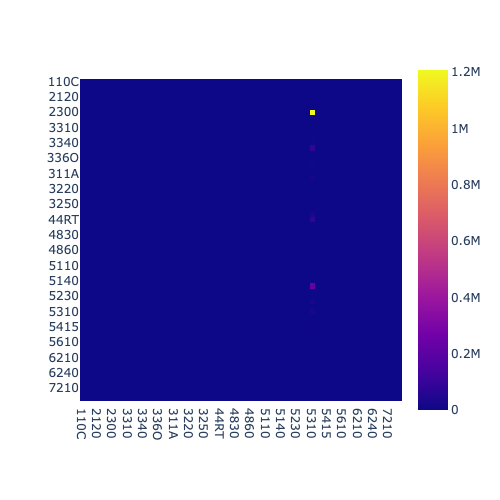

In [18]:
# px.imshow(final_resid_matrix, width=500, height=500)
Image("residmat.png")

## Final BEA Investment Network

In [19]:
bea_matrix = final_equip_matrix + final_structure_matrix + final_ipp_matrix + final_resid_matrix
px.imshow(bea_matrix, width=500, height=500)
# Image("finalbeamat.png")

##  Matrix Transformation to OECD

In [20]:
# with open("oecd_bea.json", "w") as f:
#     f.write(json.dumps(oecd_bea))

with open("oecd_bea.json", "r") as f:
    oecd_bea = json.loads(f.read())

In [21]:
# rows = []
# for i in oecd_bea.keys():
#     for j in oecd_bea[i]:
#         rows.append({
#             "oecd_code": i,
#             "bea_code": j
#         })

# pd.DataFrame(rows).to_csv("oecd_bea_crosswalk.csv", index=None)

In [37]:
tot_exp_df = expend_df[:-1].groupby("industry").agg("sum").sum(axis=1)

bea_total_exp = {}
for ind, val in tot_exp_df.items():
    bea_total_exp[ind] = val

In [23]:
# chemical and pharmaceuticals are the only two that split from BEA to OECD, here I get production ratio of OECD chemical relative to OECD pharm
icio_df = pd.read_csv("raw_data/ICIO2021_2014.csv", index_col=0)
usa_cols = icio_df.columns[icio_df.columns.map(lambda x: x.split("_")[0] == "USA")]
usa_chems = icio_df.loc[["USA_20", "USA_21"], usa_cols].sum(axis=1)
chem_ratio = usa_chems[0] / usa_chems.sum()
chem_ratio

0.6892802971158123

In [24]:
ind = []
for key, val in oecd_bea.items():
    ind = ind + val

print(len(bea_total_exp))
print(len(ind))
bea_matrix.shape

industries = list(bea_matrix.columns)
sectors = list(oecd_bea.keys())

# row summing matrix
num_splits = {}
R = np.zeros((len(sectors), len(industries)))
for sec_i, sec in enumerate(sectors):
    for ind_i, ind in enumerate(industries):
        splits = np.sum([1 for k in oecd_bea.keys() if ind in oecd_bea[k]])
        R[sec_i,ind_i] = 1 / splits if ind in oecd_bea[sec] else 0

# column weighted averaging matrix
C = np.zeros((len(industries), len(sectors)))
for ind_i, ind in enumerate(industries):
    for sec_i, sec in enumerate(sectors):
        C[ind_i, sec_i] = bea_total_exp[ind] if ind in oecd_bea[sec] else 0

# C = normalize(C, axis=0, norm='l1')

res = np.dot(np.dot(R, np.array(bea_matrix)), C)

# column-wise normalization
# res = normalize(res, axis = 0, norm='l1')

res = res / res.sum()

res = pd.DataFrame(res)
res.index = sectors
res.columns = sectors

# fix chemical split
res.loc[:, "20"] = res.loc[:, "20"] * chem_ratio
res.loc[:, "21"] = res.loc[:, "21"] * (1 - chem_ratio)

res = res[np.sort(sectors)]
res.sort_index(inplace=True)

res.to_csv('investment_recipe.csv')

63
65


In [43]:
px.imshow(res, width=500, height = 500)
#Image("finaloecdmat.png")

## Comparison to VW-based Matrix

In [26]:
vw_matrix = pd.read_csv("investment_matrix.csv", index_col=0)
px.imshow(vw_matrix, width=800, height = 800)
#Image("VWoecdmat.png")

# BEA OECD Crosswalk Confidence

Here I score each BEA/OECD match by how many overlapping subsector matches they have.

In [27]:
with open("bea_naics.json", "r") as f:
    bea_naics = json.loads(f.read())

In [28]:
bea_naics

{'110C': ['111', '112'],
 '113F': ['113', '114', '115'],
 '2110': ['211'],
 '2120': ['212'],
 '2130': ['213'],
 '311A': ['311', '312'],
 '313T': ['313', '314'],
 '315A': ['315', '316'],
 '3210': ['321'],
 '3220': ['322'],
 '3230': ['323'],
 '3240': ['324'],
 '3250': ['325'],
 '3260': ['326'],
 '3270': ['327'],
 '3310': ['331'],
 '3320': ['332'],
 '3340': ['334'],
 '3350': ['335'],
 '3330': ['333'],
 '336M': ['3361', '3362', '3363'],
 '336O': ['3364', '3365', '3366', '3367', '3368', '3369'],
 '338A': ['339'],
 '3370': ['337'],
 '2200': ['22'],
 '5620': ['562'],
 '2300': ['23'],
 '4200': ['42'],
 '44RT': ['44', '45'],
 '4850': ['485'],
 '4860': ['486'],
 '4820': ['482'],
 '4840': ['484'],
 '4830': ['483'],
 '4810': ['481'],
 '4930': ['493'],
 '487S': ['487', '488', '492'],
 '7210': ['721'],
 '7220': ['722'],
 '5110': ['511'],
 '5120': ['512'],
 '5130': ['515', '517'],
 '5140': ['518', '519'],
 '5210': ['521'],
 '5220': ['522'],
 '5230': ['523'],
 '5240': ['524'],
 '5250': ['525'],
 '5310

In [29]:
bea_naics

{'110C': ['111', '112'],
 '113F': ['113', '114', '115'],
 '2110': ['211'],
 '2120': ['212'],
 '2130': ['213'],
 '311A': ['311', '312'],
 '313T': ['313', '314'],
 '315A': ['315', '316'],
 '3210': ['321'],
 '3220': ['322'],
 '3230': ['323'],
 '3240': ['324'],
 '3250': ['325'],
 '3260': ['326'],
 '3270': ['327'],
 '3310': ['331'],
 '3320': ['332'],
 '3340': ['334'],
 '3350': ['335'],
 '3330': ['333'],
 '336M': ['3361', '3362', '3363'],
 '336O': ['3364', '3365', '3366', '3367', '3368', '3369'],
 '338A': ['339'],
 '3370': ['337'],
 '2200': ['22'],
 '5620': ['562'],
 '2300': ['23'],
 '4200': ['42'],
 '44RT': ['44', '45'],
 '4850': ['485'],
 '4860': ['486'],
 '4820': ['482'],
 '4840': ['484'],
 '4830': ['483'],
 '4810': ['481'],
 '4930': ['493'],
 '487S': ['487', '488', '492'],
 '7210': ['721'],
 '7220': ['722'],
 '5110': ['511'],
 '5120': ['512'],
 '5130': ['515', '517'],
 '5140': ['518', '519'],
 '5210': ['521'],
 '5220': ['522'],
 '5230': ['523'],
 '5240': ['524'],
 '5250': ['525'],
 '5310

In [30]:
cw_df = pd.read_csv("oecd_bea_crosswalk.csv")
cw_df["isic"] = cw_df["oecd_code"].map(lambda x: x.split("T"))
cw_df["naics"] = cw_df["bea_code"].map(lambda x: [str(i) for i in bea_naics[x]] if not type(x) is float else np.nan)

In [31]:
naics_isic = pd.read_csv("raw_data/NAICS_ISIC.csv", dtype=str)
isic_naics = pd.read_csv("raw_data/ISIC_NAICS.csv", dtype=str)

naics_isic[["ISIC4Code", "NAICS2012Code"]]

n_naics = len(naics_isic["NAICS2012Code"].unique())
n_isic = len(naics_isic["ISIC4Code"].unique())

print(len(naics_isic) - len(naics_isic) * .377)

def score_match(isic, naics, df):

    if np.nan in [isic, naics]: return 0

    naics_digits = len(naics[0])

    isic_mask = df["ISIC4Code"].map(lambda x: x[0:2] in isic)
    naics_mask = df["NAICS2012Code"].map(lambda x: type(x) is str and x[0:naics_digits] in naics)

    union = df[naics_mask | isic_mask]

    intersection = df[ naics_mask & isic_mask ]

    # print(isic)
    # print(naics)
    # display(intersection)
    # display(df[ naics_mask & ~isic_mask ])
    # display(df[ ~naics_mask & isic_mask ])

    misclass_df = pd.concat([df[ naics_mask & ~isic_mask ], df[ ~naics_mask & isic_mask ]], ignore_index=True).drop_duplicates()

    # expected_match = n_isic / n_naics
    # print(n_isic)
    # print(n_naics)
    # print(expected_match)

    return misclass_df, (len(intersection) / len(union))

score_match(cw_df.loc[2,"isic"], cw_df.loc[2,"naics"], naics_isic)

1037.295


(  NAICS2012Code NAICS2012Part ISIC4Code ISIC4Part Detail
 0        212111             0      0520        -1    NaN
 1        212112             0      0520        -1    NaN
 2        212113             0      0510        -1    NaN,
 0.5714285714285714)

In [32]:
scores = []
missclassified = []
for i, row in cw_df.iterrows():
    miss, match = score_match(row["isic"], row["naics"], naics_isic)
    missclassified.append(miss)
    scores.append(match)
missed_df = pd.concat(missclassified, ignore_index=True)
cw_df["scores"] = scores

In [33]:
pd.set_option('display.max_rows', None)
# cw_df.to_csv("oecd_bea_scored_cw.csv", index=False)
missed_df.drop_duplicates().to_csv("missclass.csv")
cw_df

,oecd_code,bea_code,isic,naics,scores
0,01T02,110C,"[01, 02]","[111, 112]",0.736264
1,03,113F,[03],"[113, 114, 115]",0.187500
2,05T06,2110,"[05, 06]",[211],0.571429
3,07T08,2120,"[07, 08]",[212],0.866667
4,09,2130,[09],[213],0.555556
5,10T12,311A,"[10, 12]","[311, 312]",0.855422
6,13T15,313T,"[13, 15]","[313, 314]",0.488372
7,13T15,315A,"[13, 15]","[315, 316]",0.120000
8,16,3210,[16],[321],0.687500
9,17T18,3220,"[17, 18]",[322],0.555556
